In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [64]:
import matplotlib.pyplot as plt, argparse, numpy as np, math, sys, copy
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
from skimage.util import img_as_float
from skimage import io
import numpy as np
import superpixels as sp
import plot as pl
import process_ground_truth as pgt
import glob
import eval_boundary as ev
import pipeline as pipe
import time
import superpixels as sp
from scipy.stats import threshold

In [3]:
ground_path = 'BSDS500/data/groundTruth/val/'
train_path = 'BSDS500/data/images/val/'
save_path = 'save/gslic/'
bound_prefix = save_path + 'images/'
eval_prefix = save_path + 'eval/'
extension = '.npz'

294


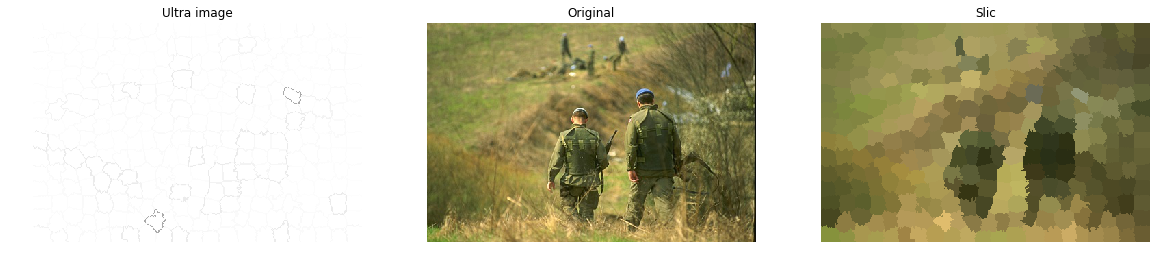

In [156]:
imagePath = 'BSDS500/data/images/val/' #'images/'
imageFile = '170057.jpg' #'3063.jpg'

image = img_as_float(io.imread((imagePath + imageFile)))

seg_slic = slic(image, n_segments = 300, slic_zero = True)
s_image, n_segs, colors = sp.color_superpixel(image, seg_slic)

img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)
ultra_image = sp.generate_ultrametric_image(img, colors, seg_slic, n_segs, step = 10
                                            , start_at = -1, stop_at = 1, black_color = False)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 20))
ax1.imshow(ultra_image)
ax1.set_title("Ultra image")
ax1.set_axis_off()
ax2.imshow(image)
ax2.set_title("Original")
ax2.set_axis_off()
ax3.imshow(s_image)
ax3.set_title("Slic")
ax3.set_axis_off()
plt.show() 

In [103]:
img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)

cutz_images, cutz_nsegs = sp.generate_ultrametric_map(img, colors, seg_slic, n_segs
                                                      , step=1, start_at = -1, stop_at = -1)
print(len(cutz_images))



1


In [129]:
ground_file = ground_path + '170057.mat' # '3063.mat'
groundtruth = pgt.get_groundTruth(ground_file)

img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
img.fill(255)
    
best_fmeasure = 0
for i in range(len(cutz_images)):
    precision, recall = ev.eval_bound(groundtruth, cutz_images[i], 0, True)
    fmeasure = 2 * ((precision * recall) / (precision + recall))
    
    print(fmeasure)
    
    if fmeasure > best_fmeasure:
        best_fmeasure = fmeasure
    
print('Best',best_fmeasure)

0.135793658885
Best 0.135793658885


In [158]:
epsilon = 0.0001 #just to round down

ground_file = ground_path + '170057.mat' # '3063.mat'
groundtruth = pgt.get_groundTruth(ground_file)

#invert groundtruth color
unique = np.unique(ultra_image)

best_fmeasure = 0
for i in unique[1:]:    
    thresh_image = threshold(ultra_image, (i - epsilon))
    
    gray_image = np.dot(thresh_image[...,:3], [0.299, 0.587, 0.114])
    
    precision, recall = ev.eval_bound(groundtruth[:,:,0], thresh_image[:,:,0], 0, True)
    fmeasure = 2 * ((precision * recall) / (precision + recall))
    
    if fmeasure > best_fmeasure:
        best_fmeasure = fmeasure
    
print('Best:', best_fmeasure)

Best: 0.145160220261


### Read Groundtruth

In [5]:
len_ground = len(ground_path)
ground_files = glob.glob(ground_path + '*.mat')
ground_filenames = [x[len_ground:-4] for x in ground_files]

groundtruths, images, names = [], [], []

#load images
for filename in ground_filenames:
    ground_file = ground_path + filename + '.mat'
    train_file = train_path + filename + '.jpg'
    
    #read groundtruth and image
    groundtruth = pgt.get_groundTruth(ground_file)
    image = img_as_float(io.imread(train_file))
    
    #append image and groundtruths
    groundtruths.append(groundtruth)
    images.append(image)
    names.append(filename + '.png')
    
print(len(groundtruths), len(images))

100 100


### Generate boundaries and save results

In [18]:
ini = 0
fim = 20 #len(ground_filenames)

methods = ['hslic']

for method in methods:
    borders = []
    last_shape = None
    img = None
    index = 0
    
    starttime = time.time()
    for image, name in zip(images[ini:fim], names[ini:fim]):
        if(image.shape != last_shape):
            img = np.zeros(image.shape,dtype=np.uint8) #create blank image to save
            last_shape = image.shape
        
        seg_slic = slic(image, n_segments = 300, slic_zero = True)
        s_image, n_segs, colors = sp.color_superpixel(image, seg_slic)
        ultra_image = sp.generate_ultrametric_image(img, colors, seg_slic, n_segs
                                                    , step = 2, start_at = -1, stop_at = (n_segs-20))
        
        if(len(ultra_image) < 300):
            print(name, len(ultra_image))
            fig, ax = plt.subplots(1,1, figsize=(20, 20))
            ax.imshow(ultra_image[0])
            plt.show() 
        
        #convert to grayscale
        gray_image = np.dot(ultra_image[...,:3], [0.299, 0.587, 0.114])
        
        #save image
        boundname = bound_prefix + name
        io.imsave(boundname, gray_image)
        
        #verbose mode
        index += 1
        if index % 10 == 0:
            print(index)

    endtime = time.time()
        
    #np.savez(boundname, borders=borders)
    print((endtime - starttime), 'seconds')

10
20
97.91602778434753 seconds


### Recover boundaries and evaluate results

In [26]:
ini = 0
fim = 20 #len(ground_filenames)

epsilon = 1e-5 #just to round down

methods = ['hslic']

for method in methods:    
    threshold = 0
    index = 0

    starttime = time.time()
    
    for groundtruth, name in zip(groundtruths[ini:fim], names[ini:fim]):
        precisions, recalls = [], []
        
        boundname = bound_prefix + name
        evalname = eval_prefix + name + extension
        
        image = img_as_float(io.imread(boundname))        
        unique = np.unique(image)
        
        #print(unique[-1])
        #invert colors
        [ground+1 for ground in groundtruth]
        groundtruth[groundtruth > 1]  = 0
                
        for thresh in unique[1:]:
            thresh_image = copy.deepcopy(image)
            thresh_image[image < (thresh + epsilon)] = 0 #round down thresh
            thresh_image[image >= (thresh + epsilon)] = 1

            #calculate values from precision and recall
            precision, recall = ev.eval_bound(groundtruth[:,:,0], thresh_image, threshold, True)
            precisions.append(precision)
            recalls.append(recall)
        
        #verbose mode
        index += 1
        if index % 10 == 0:
            print(index)
        
        #save precision file
        np.savez(evalname, precisions=precisions, recalls=recalls)
            
    endtime = time.time()
    print((endtime - starttime), 'seconds')

10
20
527.5635542869568 seconds


### Load evaluations and calculate f-measures

In [27]:
ini = 0
fim = 20 #len(ground_filenames)

methods = ['hslic']

for method in methods:
    precisions, recalls = [], []
    fmeasures = []
    
    for name in names[ini:fim]:
        evalname = eval_prefix + name + extension
        npload = np.load(evalname)
        
        print(evalname, len(npload['precisions']))
        
        precisions.append(npload['precisions'])
        recalls.append(npload['recalls'])

    len_precisions = 1000000
        
    for i in range(len(precisions)):
        if (len(precisions[i]) < len_precisions):
            len_precisions = len(precisions[i])
            
    for i in range(0,len_precisions):
        cutz_precision, cutz_recall = [], []
        
        for precision, recall in zip(precisions, recalls):
            cutz_precision.append(precision[i])
            cutz_recall.append(recall[i])
    
        np_precisions = (np.array(cutz_precision))
        np_recalls = (np.array(cutz_recall))

        fmeasure = 2 * ((np_precisions * np_recalls) / (np_precisions + np_recalls))
        fmeasures.append(fmeasure)
        
print(np.average(fmeasures, axis=1))

save/gslic/eval/126007.png.npz 9
save/gslic/eval/160068.png.npz 8
save/gslic/eval/167062.png.npz 8
save/gslic/eval/220075.png.npz 7
save/gslic/eval/170057.png.npz 3
save/gslic/eval/42049.png.npz 3
save/gslic/eval/216081.png.npz 8
save/gslic/eval/89072.png.npz 10
save/gslic/eval/55073.png.npz 6
save/gslic/eval/219090.png.npz 8
save/gslic/eval/253055.png.npz 7
save/gslic/eval/102061.png.npz 7
save/gslic/eval/38092.png.npz 4
save/gslic/eval/143090.png.npz 9
save/gslic/eval/37073.png.npz 7
save/gslic/eval/3096.png.npz 6
save/gslic/eval/86000.png.npz 8
save/gslic/eval/105025.png.npz 11
save/gslic/eval/385039.png.npz 6
save/gslic/eval/361010.png.npz 6
[ 0.91076112  0.91094672  0.92446874]
